# TO DO
* IMAGE SIZE - 512 * 64 (why?)
* try spectogram: chromagram (raw waveforms (not a spect.))
* try transformer

* TRY NORMALISE THE CHROMAGRAM
* SR - TRY TO TAKE SR VALUES FROM THE DATASET


* SIMPLE BASENET
* IMPROVE VAE NET
* LOOK INTO NSCNET ALTERNATIVES
* LOOK INTO METRIC LEARNING AND SIMILARITY RETRIEVAL

# TO ASK THE TUTOR

WHAT THE TUTOR SAID

noise: analyzing the noise in an empirical way--> listening to the songs
alternative: we could fine tune the threshold

normalize out of all the songs

make sure the padding doesn't interfere with other images

# look at the data
analyze duration, understand how big to make the chromagram images

    the images are the same size, but the same amount of of time is different in different signals
    
    let's choose a threshold where to truncate and pad
    
analyze frequencies, are there frequencies we should cut

    is there noise we should cut (we don't think so)
    
do the chromagram

# Utils

* https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/

* https://ridakhan5.medium.com/audio-clustering-with-deep-learning-a7991d605fa5

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://www.researchgate.net/publication/333427516_Feature_Learning_for_Bird_Call_Clustering

* https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://musicinformationretrieval.com/kmeans.html

* Feature Normalization: https://www.hackaudio.com/digital-signal-processing/amplitude/peak-normalization/#:~:text=Normalizing%20the%20amplitude%20of%20a,magnitude%20equals%20a%20specified%20level.&text=This%20opens%20in%20a%20new%20window.&text=Peak%20amplitude%20is%20a%20measurement%20based%20the%20instantaneous%20level%20of%20a%20signal.

* https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_FeatureNormalization.html

* https://stackoverflow.com/questions/48257311/signal-processing-can-someone-explain-for-me-the-different-type-of-spectrogram

* https://www.geeksforgeeks.org/plotting-a-spectrogram-using-python-and-matplotlib/

* https://it.mathworks.com/matlabcentral/answers/319352-how-do-i-perform-clustering-of-audio-signal

wav files seconds
* https://stackoverflow.com/questions/13039846/what-do-the-bytes-in-a-wav-file-represent

In [ ]:
#!pip install librosa
from pathlib import Path
import os
import pandas as pd
import librosa
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
#constants
SR = 22050

In [ ]:
DIR = './drive/MyDrive/Colab Notebooks/aiti_project/dataset/songs_extracted'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive

Mounted at /content/drive
 apartments.gsheet   Old_dl_colab_notebooks
'Colab Notebooks'    tiny-imagenet-200.zip


In [ ]:
#function that loads the songs from the songs_extracted dataset
def load_songs_extracted(directory):
    data = []
    for bird_names in os.listdir(directory):#[:1]:
        path_bird_names = os.path.join(directory, bird_names)
        if os.path.isdir(path_bird_names):
            for channel in os.listdir(path_bird_names):
                if channel == "CH2":
                    path_channel  = os.path.join(path_bird_names, channel)
                    if os.path.isdir(path_channel):
                        for song in  os.listdir(path_channel):
                            song_num = int(re.search('\d+', song).group())
                            path_song = os.path.join(path_channel, song)
                            signal, sr = librosa.load(path_song)
                            data.append([bird_names, song_num, sr, signal]) #channel is CH2 by default

    # return dataframe creation
    return pd.DataFrame(data, columns=['bird', 'song', 'sr', 'signal'])

In [ ]:
df = load_songs_extracted(Path(DIR))
df.head()

,bird,song,sr,signal
0,andrei_bos,102,22050,"[-0.004434305, -0.0046334974, -0.0007038029, 0..."
1,andrei_bos,119,22050,"[-0.0023026452, -0.0045605716, -0.0018705465, ..."
2,andrei_bos,103,22050,"[-0.0030055528, -0.004927803, -0.0034849318, -..."
3,andrei_bos,106,22050,"[0.00016273024, 0.00023529833, 0.00029498542, ..."
4,andrei_bos,110,22050,"[0.00023514929, 0.0016683282, 0.003041996, 0.0..."


In [ ]:
df.shape

(1624, 4)

In [ ]:
print(df['signal'][0].shape)
print(df['signal'][0])

(97462,)
[-0.0044343  -0.0046335  -0.0007038  ...  0.00019592  0.00109899
  0.00162328]


In [ ]:
import IPython.display as ipd
ipd.Audio(df.iloc[0]['signal'], rate=SR)

# Preprocessing

truncation: understand if having signals of different length is a problem

normalization: understand how and if to normalize (-1,1)

### Padding

In [ ]:
def pad_signals(df, policy = "truncation", seconds = 11):

    df['signal_length'] = df['signal'].apply(lambda x: len(x))
    mean = np.mean(df['signal_length'])
    mean = int(mean)
    print('mean:', mean)
    print('standard deviation:', np.std(df['signal_length']))
    print(df[df['signal_length'] < 100000]['signal_length'].count(), 'signals are not truncated out of', df['signal_length'].count())

    if policy == 'padding':
        maxim = np.max(df['signal_length'])
        print(maxim)
        df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, maxim-len(x))) )

    elif policy == 'truncation':
        #TODO truncation
        trunc_thresh = seconds*22050  #maxim
        #padding
        df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, trunc_thresh-len(x))) if len(x)<trunc_thresh else x) 
        #truncation
        df['padded_signal'] = df['padded_signal'].apply(lambda x: x[0:trunc_thresh] if len(x)>trunc_thresh else x) 

    print(len(df['padded_signal'][1]))
    return df    

In [ ]:
df = pad_signals(df, policy = "truncation", seconds = 11)

mean: 67598
standard deviation: 28258.9074562869
1472 signals are not truncated out of 1624
242550


### Amplitude Normalization
if we want to normalize the signals using their own max value for each, we don't need to do it
cause the chromagram ALREADY DOES IT

we can try to normalize all the signals together using the highest value in all the dataset
so the relationships between signal amplitudes is kept

here we are doing the first method

In [ ]:
max_df = df['padded_signal'].apply(lambda x : np.max(np.abs(x))).max()
print(max_df)

0.8427134


In [ ]:
df['normalized_signal'] = df['padded_signal'].apply(lambda x: x/max_df)

#df['normalized_signal'] = df['padded_signal'].apply(lambda x: x/np.max(np.abs(x)))
print(np.max(np.abs(df['normalized_signal'][0])))

0.662962


### Filtering
We read on nscnet that they removed the noise.
We followed their idea, but are not sure if ch1 (the one they used) is more noisy than ch2 and so we don't need it.

We need to find a way to properly asses the level of noise in the data.

In [ ]:
sr = SR     
order = 5
lf = 1500
filtered = []
def high_pass(sig):
    nyq = sr/2
    sos = butter(order, [lf/nyq], analog=False, btype='highpass', output='sos')
    return sosfiltfilt(sos,sig)

df['filtered_signal'] = df['padded_signal'].apply(lambda x: high_pass(x))    

### Chromagrams

In [ ]:
chromagrams = []
for signal in df['filtered_signal']:
    chrom = librosa.feature.chroma_stft(y=signal, sr=SR)
    chromagrams.append(chrom)
    
#chromagrams = df['normalized_signal'].apply(lambda x: librosa.feature.chroma_stft(y=x, sr=SR))

In [ ]:
#chromagrams

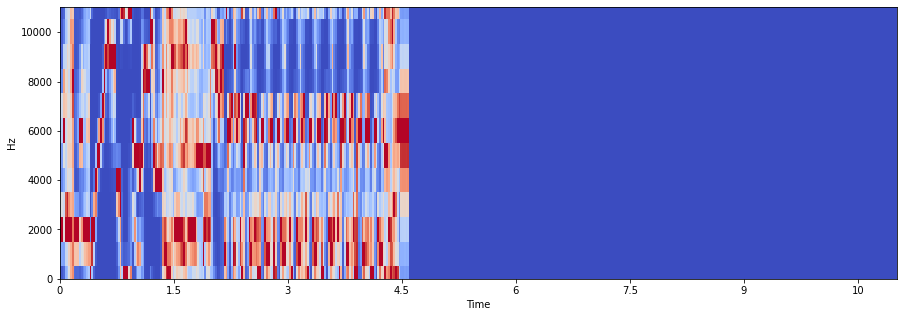

In [ ]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[0], x_axis='time', y_axis='hz', hop_length=512, cmap='coolwarm')

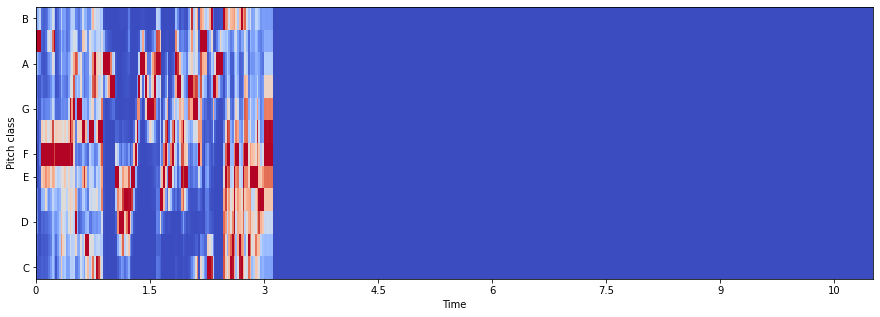

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[120], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

## PCA
n_components: either automatic, or with 12 (because we have 12 pitches)

In [ ]:
chromagrams_array = np.array(chromagrams)
print(chromagrams[0].shape)
print(chromagrams_array.shape)

#x = pca.fit_transform(chromagrams_array)

#pca_chromagrams = chromagrams_array.apply(lambda x: pca.fit_transform(x))

pca_chromagrams = []
for x in chromagrams:
    res = PCA().fit_transform(x)
    res = res.reshape(res.shape[0]*res.shape[1])
    pca_chromagrams.append(res)

(12, 474)
(1624, 12, 474)


In [ ]:
chromagrams_array[0, :, :]

array([[0.02699388, 0.03137827, 0.06908664, ..., 0.        , 0.        ,
        0.        ],
       [0.20307193, 0.21929792, 0.20763572, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.51730488, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03001455, 0.07000478, 0.39137517, ..., 0.        , 0.        ,
        0.        ],
       [0.03268133, 0.04478961, 0.11847596, ..., 0.        , 0.        ,
        0.        ],
       [0.02639347, 0.03067261, 0.06150489, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
#librosa.display.specshow(pca_chromagrams[3], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

In [ ]:
'''squared_distances = []
for k in range(1,15):
    km = KMeans(n_clusters=k)
    km = km.fit_transform(pca_chromagrams)
    squared_distances.append(km.inertia_)'''

#clusters = KMeans(n_clusters=8, max_iter=10, random_state=0).fit_transform(pca_chromagrams)
#print(clusters)

cluster_number = range(2,120) 

distortions = []
silhouette_scores = []
for n in cluster_number:
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(pca_chromagrams)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(pca_chromagrams,y))

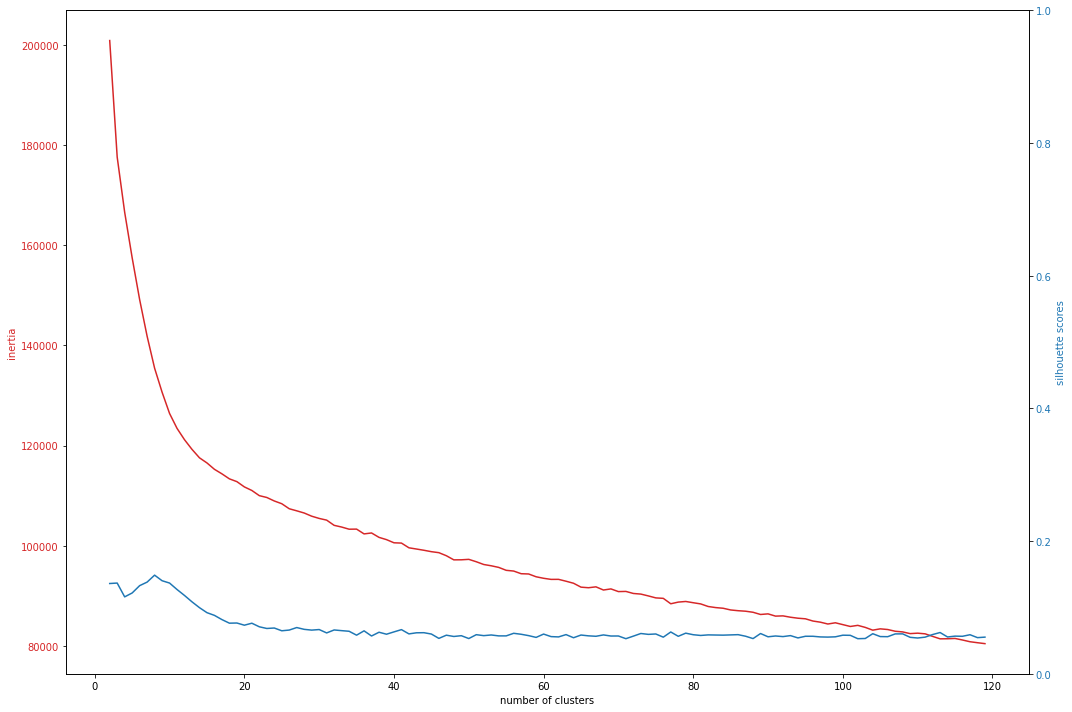

In [ ]:
# Create some mock data
t = cluster_number
data1 = distortions
data2 = silhouette_scores

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

there's no elbow O.O

In [ ]:
#librosa.display.specshow(clusters, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

FOR KMEANS CLUSTERING:
compute the predictions:   cluster_predictions = kmeans.fit_predict(x)
find an evaluation method he uses silhouette score

### plot

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show() 

In [ ]:
X = np.array(pca_chromagrams)
print(X.shape)

(1624, 144)


In [ ]:
# to fill
good_k = 15

estimator = KMeans(n_clusters = good_k, init='k-means++', n_init=10, max_iter=300,)
y = estimator.fit_predict(X)

#estimator.cluster_centers_

In [ ]:
#import seaborn as sns
#sns.pairplot(pd.DataFrame(X[:,0:10]))

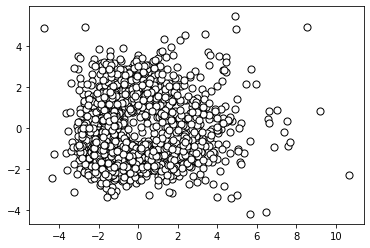

In [ ]:
plt.scatter(X[:,0], X[:,1], c='white', edgecolors='black', marker='o', s=50)

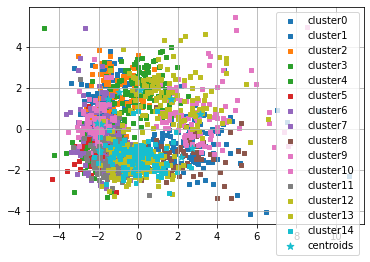

In [ ]:
plot_clusters(X, y, dim= (0,1), points= estimator.cluster_centers_)
              #, ['cluster0', 'cluster1', 'cluster2'], ['centroids'],
             #['blue', 'red', 'pink'], ['cyan'])

# getting pngs

In [ ]:
from tqdm import tqdm

In [ ]:
#import shutil

#shutil.rmtree('chromagrams')

In [ ]:
!mkdir chromagrams

In [ ]:
plt.figure(figsize=(30, 10))
print("Saving the chromagrams as png images. It may take a while...")
for i in tqdm(range(len(chromagrams))):
    librosa.display.specshow(chromagrams[i], hop_length=512, cmap='coolwarm')
    if not os.path.exists("chromagrams/" + str(i) + "out.png"):
        plt.savefig("chromagrams/" + str(i) + "out.png", bbox_inches='tight', facecolor='white')
    plt.clf()

Saving the chromagrams as png images. It may take a while...


100%|██████████| 1624/1624 [03:47<00:00,  7.15it/s]


<Figure size 2160x720 with 0 Axes>

# CONTRASTIVE LEARNING

In [ ]:
## Standard libraries
'''import os
from copy import deepcopy

from torch.utils.data import Dataset, DataLoader
import tensorflow as tf

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard'''

"import os\nfrom copy import deepcopy\n\nfrom torch.utils.data import Dataset, DataLoader\nimport tensorflow as tf\n\n## Imports for plotting\nimport matplotlib.pyplot as plt\nplt.set_cmap('cividis')\n%matplotlib inline\nfrom IPython.display import set_matplotlib_formats\nset_matplotlib_formats('svg', 'pdf') # For export\nimport matplotlib\nmatplotlib.rcParams['lines.linewidth'] = 2.0\nimport seaborn as sns\nsns.set()\n\n## tqdm for loading bars\nfrom tqdm.notebook import tqdm\n\n## PyTorch\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.utils.data as data\nimport torch.optim as optim\n\n## Torchvision\nimport torchvision\nfrom torchvision.datasets import STL10\nfrom torchvision import transforms\n\n# PyTorch Lightning\ntry:\n    import pytorch_lightning as pl\nexcept ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary\n    !pip install --quiet pytorch-lightning>=1.4\n    import 

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

## tqdm for loading bars
from tqdm.notebook import tqdm

import tensorflow as tf

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

## Torchvision
import torchvision
from torchvision import transforms

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "chromagrams/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models"

In [ ]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#print("Device:", device)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        #x[:,0:460] = 1.0
        #x = np.reshape(x, x.shape + (1,))
        #print(x.shape)
        if self.transform:
            x = self.transform(x)
        #print(x.shape)    
        return x
    
    def __len__(self):
        return len(self.data)

data augmentation

In [ ]:
transform1 = transforms.Compose([transforms.ToTensor(), transforms.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.1, 0.3), value=1, inplace=False)])
augmented_dataset1 = MyDataset(np.copy(chromagrams), transform1) #, transform
train_dataloader1 = torch.utils.data.DataLoader(augmented_dataset1, batch_size=1, shuffle = False)

transform2 = transforms.Compose([transforms.ToTensor(), torchvision.transforms.RandomAffine(degrees = 0, translate = (0.1, 0))])
augmented_dataset2 = MyDataset(np.copy(chromagrams), transform2)
train_dataloader2 = torch.utils.data.DataLoader(augmented_dataset2, batch_size=1, shuffle = False)

'''for index, img in enumerate(train_dataloader1):
    print(img.shape)
    plt.imshow(chromagrams[index], aspect = 'auto', cmap = "gray")
    plt.show()
    plt.imshow(img[0].permute(1, 2, 0)[:, :, 0], aspect = 'auto', cmap = "gray")
    plt.show()'''

'for index, img in enumerate(train_dataloader1):\n    print(img.shape)\n    plt.imshow(chromagrams[index], aspect = \'auto\', cmap = "gray")\n    plt.show()\n    plt.imshow(img[0].permute(1, 2, 0)[:, :, 0], aspect = \'auto\', cmap = "gray")\n    plt.show()'

shape [batch_size, 1, 12, 474]

for now we tried with these two tranformations, but we're keeping them separate.
A good idea could be to apply both, and maybe even more, to both augmented datasets, since they're random.

The first transform is random erasing, which adds a white patch.

The second transform is randomaffine, which we made translate the image.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Create TensorFlow dataset
BATCH_SIZE = 64

transform = transforms.Compose([#transforms.ToTensor(),
                                #transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.RandomAffine(degrees=0, translate=(0.1,0)),
                                transforms.RandomErasing(p=0.4, scale=(0.02, 0.03), ratio=(0.2,0.3), value=0.6, inplace=False),  
                                transforms.RandomErasing(p=0.4, scale=(0.02, 0.1), ratio=(0.02,0.05), value=0.9, inplace=False)
                               ])

train_dataset = MyDataset(np.copy(chromagrams))  #WITHOUT AUGMENTATIONS

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True) #drop last false?

'''for index, img in enumerate(train_dataloader):
    print(img.shape)
    plt.imshow(img[0].permute(1, 2, 0)[:, :, 0], aspect = 'auto')
    plt.show()'''

"for index, img in enumerate(train_dataloader):\n    print(img.shape)\n    plt.imshow(img[0].permute(1, 2, 0)[:, :, 0], aspect = 'auto')\n    plt.show()"

In [ ]:
print(type(train_dataset[0]))

for index, img in enumerate(train_dataloader):
    torch.reshape(img[0], (1, img[0].shape[0], img[0].shape[1]))
    print(img[0].shape)
    print(type(img[0]))
    img = transform(img[0])
    print(img.shape)
    print(type(train_dataset[0]))

<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.Tensor'>
torch.Size([3, 12, 474])
<class 'numpy.ndarray'>
torch.Size([12, 474])
<class 'torch.

creating the model

In [ ]:
#official resnet implementation, with number of channels turned to 1 instead of 3 in conv1
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)


class SimCLRModel(nn.Module):
    def __init__(self):
      super(SimCLRModel, self).__init__()
      self.resnet = torchvision.models.resnet50(weights=None)  #maybe we could use some already existing weights
      
      #self.resnet = ResNet(models.resnet.Bottleneck, [3, 8, 36, 3], pretrained = False)    #if we want to use a 1d tensor, but it might be easier to just paste it three times onto a 3d tensor
      #self.avgpool = torch.nn.AvgPool2d()   #it flattens one dimension? if that's it we already have a 2d array
      self.fc1 = nn.Linear(1000, 256)   #not sure about 1000
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn.Linear(128, 50)
      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.resnet(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      return x

In [ ]:
model = SimCLRModel()

model = model.to(device)

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model, (3, 12, 474))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 6, 237]           9,408
       BatchNorm2d-2           [-1, 64, 6, 237]             128
              ReLU-3           [-1, 64, 6, 237]               0
         MaxPool2d-4           [-1, 64, 3, 119]               0
            Conv2d-5           [-1, 64, 3, 119]           4,096
       BatchNorm2d-6           [-1, 64, 3, 119]             128
              ReLU-7           [-1, 64, 3, 119]               0
            Conv2d-8           [-1, 64, 3, 119]          36,864
       BatchNorm2d-9           [-1, 64, 3, 119]             128
             ReLU-10           [-1, 64, 3, 119]               0
           Conv2d-11          [-1, 256, 3, 119]          16,384
      BatchNorm2d-12          [-1, 256, 3, 119]             512
           Conv2d-13          [-1, 256, 3, 119]          16,384
      BatchNorm2d-14          [-1, 256,

loss function

In [ ]:
negative_mask = np.ones((BATCH_SIZE, 2 * BATCH_SIZE), dtype=bool)
for i in range(BATCH_SIZE):
    negative_mask[i, i] = 0
    negative_mask[i, i + BATCH_SIZE] = 0
negative_mask = torch.from_numpy(negative_mask).to(device)

def loss_fn(xis, xjs, model, optimizer, criterion, temperature):
  optimizer.zero_grad()

  xis = xis.to(device)
  xjs = xjs.to(device)

  xis = xis.float()
  xjs = xjs.float()
  #print(xis.shape)
  zis = model(xis)
  zjs = model(xjs)

  zis = torch.nn.functional.normalize(zis, p=2, dim=1)
  zjs = torch.nn.functional.normalize(zjs, p=2, dim=1)

  #tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
  #l_pos = sim_func_dim1(zis, zjs)
  l_pos = torch.matmul(torch.unsqueeze(zis, 1), torch.unsqueeze(zis, 2))
  l_pos = torch.reshape(l_pos, (BATCH_SIZE, 1))
  l_pos = l_pos / temperature

  negatives = torch.cat([zjs, zis], axis=0)

  loss = 0

  for positives in [zis, zjs]:
    
      cosine_sim_2d = torch.nn.CosineSimilarity(dim=2, eps=1e-08)
      l_neg = cosine_sim_2d(torch.unsqueeze(positives, 1), torch.unsqueeze(negatives, 0))

      labels = torch.zeros(BATCH_SIZE, dtype=torch.int32).type(torch.LongTensor).to(device)

      l_neg = torch.masked_select(l_neg, negative_mask)
      l_neg = torch.reshape(l_neg, (BATCH_SIZE, -1))
      l_neg = l_neg / temperature

      logits = torch.cat([l_pos, l_neg], axis=1)
      loss += criterion(input=logits, target=labels)

  loss = loss / (2 * BATCH_SIZE)

  loss.backward()
  optimizer.step()

  return loss

training function

In [ ]:
def train_simclr(model, dataloader, optimizer, criterion,
                 temperature=0.1, epochs=3):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataloader:
            a = transforms.Lambda(lambda x: torch.stack([transform(x_) for x_ in x]))(image_batch)
            b = transforms.Lambda(lambda x: torch.stack([transform(x_) for x_ in x]))(image_batch)

            loss = loss_fn(a, b, model, optimizer, criterion, temperature).item()
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))    #does the mean make sense. find out in the next episode
        
        print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

TODO

run it on the model

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
epoch: 1 loss: 0.050
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12, 474])
torch.Size([64, 3, 12,

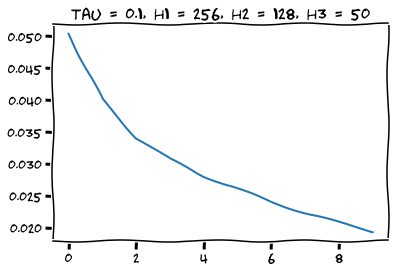

In [ ]:
LEARNING_RATE = 1e-3

criterion = torch.nn.CrossEntropyLoss()
#decay_steps = 1000

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=LEARNING_RATE/50) #t_max = max_epochs

epoch_wise_loss, model_trained  = train_simclr(model, train_dataloader, optimizer, criterion,
                 temperature=0.1, epochs=10)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [ ]:
#chromagrams is an array, we need tensors

transform_test = transforms.Compose([transforms.ToTensor(),
                                #transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1)),
                                #transforms.RandomAffine(degrees=0, translate=(0.1,0)),
                                #transforms.RandomErasing(p=0.4, scale=(0.02, 0.03), ratio=(0.2,0.3), value=0.6, inplace=False),  
                                #transforms.RandomErasing(p=0.4, scale=(0.02, 0.1), ratio=(0.02,0.05), value=0.9, inplace=False)
                               ])

test = transform_test(chromagrams_array)
test = test.permute((2, 0, 3, 1)).to(device).float()
print(chromagrams_array.shape)
print(test.shape)

features = model(test)

print(features.shape)

features = features.detach().cpu().numpy()

OutOfMemoryError: ignored

clustering

with calinsky score

In [ ]:
from sklearn.metrics import calinski_harabasz_score

cluster_number = range(2,20) 

distortions = []
silhouette_scores = []
calinski_harabasz_scores = []
for n in cluster_number:
    print(n, end=' ')
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(features)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(features,y))
    calinski_harabasz_scores.append(calinski_harabasz_score(features,y))
print()

In [ ]:
t = cluster_number
data1 = distortions
data2 = calinski_harabasz_scores #silhouette_scores

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('calinski_harabasz_scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(-0.03,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()
print(features[0].shape)

In [ ]:
good_k = 10

estimator = KMeans(n_clusters = good_k, init='k-means++', n_init=10, max_iter=300,)
y = estimator.fit_predict(features)

In [ ]:
plot_clusters(features, y, dim= (0,1), points= estimator.cluster_centers_)

clustering

with silouhette score

various tests

do not run

In [ ]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs = batch
        print(imgs.shape)
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [ ]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = torch.utils.data.DataLoader(augmented_dataset1, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True)
        #train_loader = train_dataloader1
        #val_loader = data.DataLoader(augmented_dataset2, batch_size=batch_size, shuffle=False,drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [ ]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

NameError: ignored

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)


import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [ ]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [ ]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [ ]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))

In [ ]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)

print(imgs[0].shape)

img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [ ]:
from imutils import paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image


# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
print(train_ds)